In [4]:
# pip install pandas scikit-learn matplotlib seaborn keras tensorflow xgboost lightgbm catboost scipy
# %pip install 

In [5]:
# import and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.stats import ttest_ind, norm
from sklearn.feature_selection import mutual_info_regression

# data_dict_csv = pd.read_csv(r"2025_Problem_C_Data\data_dictionary.csv")
athletes = pd.read_csv(r"2025_Problem_C_Data\summerOly_athletes.csv")
hosts = pd.read_csv(r"2025_Problem_C_Data\summerOly_hosts.csv")
medal = pd.read_csv(r"2025_Problem_C_Data\summerOly_medal_counts.csv")
programs = pd.read_csv(r"2025_Problem_C_Data\summerOly_programs.csv", encoding='windows-1252')
hosts = hosts.drop(hosts.index[hosts['Year'].isin([1916, 1940, 1944])]) #Drop years during WW
athletes['NOC'] = athletes['NOC'].replace('AIN', 'ROC') #2024 ROC Team
programs.rename(columns={'1906*': '1906'}, inplace=True) #Replace 906* as 1906

y_2028_sports = pd.read_csv(r"2025_Problem_C_Data\summerOly_2028_Sports.csv")


In [6]:
# define functions
def medal_count_for_each_sport(athletes):
    train = (
        athletes[['Year', 'NOC', 'Sport', 'Event', 'Medal']]
        .drop_duplicates()
        .groupby(['Year', 'NOC', 'Sport', 'Medal'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    ).sort_values(by=['Year', 'Gold', 'Silver', 'Bronze'], ascending=[False, False, False, False])
    
    athlete_count = (
        athletes[['Year', 'NOC', 'Sport', 'Name']]
        .drop_duplicates()
        .groupby(['Year', 'NOC', 'Sport'])
        .size()
        .reset_index(name='Athlete_Count')
    )
    
    total_athlete_count = (
        athletes[['Year', 'Sport', 'Name']]
        .drop_duplicates()
        .groupby(['Year', 'Sport'])
        .size()
        .reset_index(name='Total_Athlete_Count')
    )

    train = train.merge(athlete_count, on=['Year', 'NOC', 'Sport'], how='left')
    train = train.merge(total_athlete_count, on=['Year', 'Sport'], how='left')
    train['Athlete_Proportion'] = train['Athlete_Count'] / train['Total_Athlete_Count']

    train = train.loc[:, ['Year', 'NOC', 'Sport', 'Gold', 'Silver', 'Bronze', 'No medal', 'Athlete_Count', 'Total_Athlete_Count', 'Athlete_Proportion']]
    train = train.fillna(0)
    return train.reset_index(drop=True)

def create_2028_row(train):
    df_2028 = train[(train['Year'] >= 1999)]
    noc_sport_combinations = df_2028.groupby(['NOC', 'Sport']).size().reset_index()[['NOC', 'Sport']]
    new_rows = pd.DataFrame({
        'Year': 2028,
        'NOC': noc_sport_combinations['NOC'],
        'Sport': noc_sport_combinations['Sport'],
        'Gold': 0,
        'Silver': 0,
        'Bronze': 0,
        'No medal': 0,
        'Athlete_Count': 0,
        'Total_Athlete_Count': 0,
        'Athlete_Proportion': 0.0
    })

    return pd.concat([new_rows, train], ignore_index=True)

def merge_hosts(train, hosts):
    country_to_noc = {
        "United States": "USA",
        "United Kingdom": "GBR",
        "France": "FRA",
        "Australia": "AUS",
        "Japan": "JPN",
        "Germany": "GER",
        "Greece": "GRE",
        "Brazil": "BRA",
        "China": "CHN",
        "Spain": "ESP",
        "South Korea": "KOR",
        "Russia": "RUS",
        "Canada": "CAN",
        "Mexico": "MEX",
        "Italy": "ITA",
        "Finland": "FIN",
        "Netherlands": "NED",
        "Belgium": "BEL",
        "Sweden": "SWE",
    }
    hosts['Country'] = hosts['Host'].str.split(',').str[-1].str.strip()
    hosts['NOC'] = hosts['Country'].map(country_to_noc)
    hosts.loc[hosts['Year'] == 1972, 'NOC'] = 'FRG'
    hosts.loc[hosts['Year'] == 1980, 'NOC'] = 'URS'
    hosts.loc[hosts['Year'] == 2020, 'NOC'] = 'JPN'
    hosts = hosts.drop(['Host', 'Country'], axis=1)

    train = pd.merge(train, hosts, on='Year', how='left', suffixes=('', '_host'))
    train['NOC_if_host'] = train.apply(lambda row: 1 if row['NOC'] == row['NOC_host'] else 0, axis=1)
    return train


def add_2028_sports(programs, y_2028_sports):
    programs['Discipline'] = programs['Discipline'].fillna(programs['Sport'])

    programs['Sport'] = programs['Sport'].str.replace('\xa0', ' ', regex=True)

    programs['Sport'] = programs['Sport'].str.lower()
    programs['Discipline'] = programs['Discipline'].str.lower()
    y_2028_sports['Sport'] = y_2028_sports['Sport'].str.lower()
    y_2028_sports['Discipline'] = y_2028_sports['Discipline'].str.lower()

    programs = programs.merge(y_2028_sports, how='left', left_on=['Sport', 'Discipline'], right_on=['Sport', 'Discipline'])
    programs['2028'] = programs['2028'].fillna(0).astype(int)
    programs.loc[71, '2028'] = programs.loc[:70, '2028'].sum()

    return programs

def merge_programs(train, programs):
    sport_to_code_mapping = {
        'Athletics': 'ATH',
        'Hockey': 'HOC',
        'Football': 'FBL',
        'Wrestling': 'WRF',
        'Boxing': 'BOX',
        'Judo': 'JUD',
        'Taekwondo': 'TKW',
        'Shooting': 'SHO',
        'Swimming': 'SWM',
        'Cycling Road': 'CRD',
        'Weightlifting': 'PBT',
        'Fencing': 'FEN',
        'Synchronized Swimming': 'SWA',
        'Sailing': 'SAL',
        'Equestrianism': 'EDR',
        'Triathlon': 'TRI',
        'Cycling': 'CTR',
        'Artistic Gymnastics': 'GAR',
        'Gymnastics': 'GAR',
        'Handball': 'HBL',
        'Tennis': 'TEN',
        'Volleyball': 'VVO',
        'Rowing': 'ROW',
        'Table Tennis': 'TTE',
        'Trampolining': 'GTR',
        'Badminton': 'BDM',
        'Canoe Sprint': 'CSP',
        'Karate': 'KTE',
        'Marathon Swimming': 'OWS',
        'Canoe Slalom': 'CSL',
        'Canoeing': 'CSP', 
        'Basketball': 'BKB',
        'Beach Volleyball': 'VBV',
        'Rugby': 'RUG',
        'Diving': 'DIV',
        'Figure Skating': 'FSK',
        'Polo': 'POL',
        'Water Polo': 'WPO',
        'Art Competitions': None,
        'Modern Pentathlon': 'MPN',
        'Archery': 'ARC',
        'Golf': 'GLF',
        'Rugby Sevens': 'RU7',
        'Cycling BMX Racing': 'BMX',
        'Cycling Mountain Bike': 'MTB',
        'Equestrian': 'EDR',
        'Surfing': 'SRF',
        'Cycling BMX Freestyle': 'BMF',
        'Skateboarding': 'SKB',
        'Rhythmic Gymnastics': 'GRY',
        'Softball': 'SBL',
        'Baseball': 'BSB',
        'Cycling Track': 'CTR',
        'Artistic Swimming': 'SWA',
        'Baseball/Softball': 'BSB',
        'Sport Climbing': 'CLB',
        'Trampoline Gymnastics': 'GTR',
        '3x3 Basketball': 'BK3',
        'Breaking': 'BKG',
        'Tug-Of-War': 'TOW',
        'Ice Hockey': 'IHO',
        'Lacrosse': 'LAX',
        'Basque Pelota': 'PEL',
        'Croquet': 'CQT',
        'Cricket': 'CKT',
        'Motorboating': None,
        'Racquets': 'RQT',
        'Jeu De Paume': '\x96',
        'Alpinism': None, 
        'Aeronautics': None,
        'Roque': 'ROC'
    }
    
    train['Sport_Code'] = train['Sport'].map(sport_to_code_mapping)
    
    year_columns = [str(year) for year in list(range(1896, 2025, 4)) + ['1906']]
    for year_to_remove in ['1940', '1944', '1916']:
        year_columns = [year for year in year_columns if year != year_to_remove]
    
    melted_programs = pd.melt(
        programs,
        id_vars=['Sport', 'Discipline', 'Code', 'Sports Governing Body'],
        value_vars=year_columns,
        var_name='Year',
        value_name='Number_of_Events'
    ).sort_values(by=['Year', 'Sport'], ascending=[False, True]).loc[:, ['Year', 'Code', 'Number_of_Events']].fillna(0)
    
    train['Year'] = train['Year'].astype(int)
    melted_programs['Year'] = melted_programs['Year'].astype(int)
    
    merged_df = train.merge(
        melted_programs,
        left_on=['Year', 'Sport_Code'],
        right_on=['Year', 'Code'],
        how='left'
    ).drop(['Sport','Code'], axis=1)
    
    return merged_df

def add_EWA_column(train):
    GOLD_WEIGHT = 0.5
    SILVER_WEIGHT = 0.3
    BROUNZE_WEIGHT = 0.2
    beta = 0.8

    train['current_year_value'] = (
        (GOLD_WEIGHT * train['Gold'] + SILVER_WEIGHT * train['Silver'] + BROUNZE_WEIGHT * train['Bronze']) /
        (train['Gold'] + train['Silver'] + train['Bronze'] + train['No medal'])
    )
    # TODO: change to number of envent athlete["event"]

    train = train.sort_values(by=['NOC', 'Year'])
    train['EWA'] = 0

    for noc, group in train.groupby('NOC'):
        ewa = 0
        t=1
        for idx, row in group.iterrows():
            # Update EWA based on the formula
            ewa = (beta * ewa + (1 - beta) * row['current_year_value'])/(1-beta**t)
            
            train.loc[idx, 'EWA'] = ewa
            t += 1
    train.drop(columns=['current_year_value'], inplace=True)
    return train


In [7]:
train = medal_count_for_each_sport(athletes)
train = create_2028_row(train)
train = merge_hosts(train, hosts)
programs = add_2028_sports(programs, y_2028_sports)
train = merge_programs(train,programs)
train = add_EWA_column(train)
train

,Year,NOC,Gold,Silver,Bronze,No medal,Athlete_Count,Total_Athlete_Count,Athlete_Proportion,NOC_host,NOC_if_host,Sport_Code,Number_of_Events,EWA
27586,1936,AFG,0,0,0,3,2,776,0.002577,GER,0,ATH,29,0.0
27587,1936,AFG,0,0,0,1,13,167,0.077844,GER,0,HOC,1,0.0
27073,1948,AFG,0,0,0,1,10,217,0.046083,GBR,0,FBL,1,0.0
27074,1948,AFG,0,0,0,1,12,184,0.065217,GBR,0,HOC,1,0.0
25992,1956,AFG,0,0,0,1,12,173,0.069364,AUS,0,HOC,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,2028,ZIM,0,0,0,0,0,0,0.000000,USA,0,ROW,NaN,NaN
3450,2028,ZIM,0,0,0,0,0,0,0.000000,USA,0,SHO,NaN,NaN
3451,2028,ZIM,0,0,0,0,0,0,0.000000,USA,0,SWM,NaN,NaN
3452,2028,ZIM,0,0,0,0,0,0,0.000000,USA,0,TEN,NaN,NaN


**PLOT**

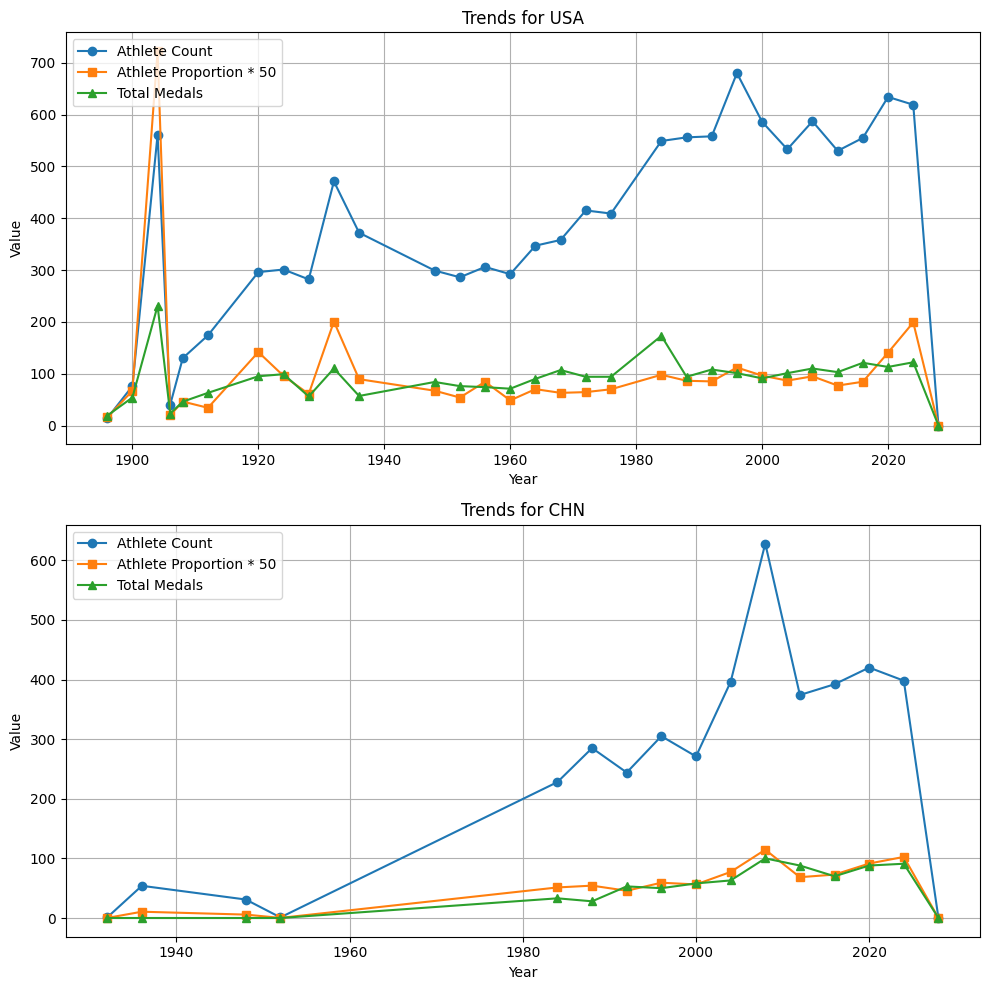

<Figure size 640x480 with 0 Axes>

In [8]:
# different year athlete number v.s. medal earned in USA and China
athletes_effect = train.loc[:, ['Year', 'NOC', 'Gold', 'Silver','Bronze', 'Athlete_Count', 'Athlete_Proportion']].groupby(['Year', 'NOC']).sum().reset_index()
athletes_effect['Total_Medals'] = athletes_effect['Gold'] + athletes_effect['Silver'] + athletes_effect['Bronze']

selected_countries = ['USA', 'CHN']
filtered_data = athletes_effect[athletes_effect['NOC'].isin(selected_countries)]

# Plot trends for each country
fig, axes = plt.subplots(len(selected_countries), 1, figsize=(10, 5 * len(selected_countries)))

for i, country in enumerate(selected_countries):
    country_data = filtered_data[filtered_data['NOC'] == country]
    axes[i].plot(country_data['Year'], country_data['Athlete_Count'], label='Athlete Count', marker='o')
    axes[i].plot(country_data['Year'], country_data['Athlete_Proportion']*50, label='Athlete Proportion * 50', marker='s')
    axes[i].plot(country_data['Year'], country_data['Total_Medals'], label='Total Medals', marker='^')
    
    # Set titles and labels
    axes[i].set_title(f'Trends for {country}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig("Correlation of (Athlete_Count and Athlete_Proportion) and Total_Medals.png", dpi=300, bbox_inches='tight')


In [9]:
# Correlation matrix for averaged data:
average_data = athletes_effect.groupby('Year').agg({
    'Athlete_Count': 'mean',
    'Athlete_Proportion': 'mean',
    'Total_Medals': 'mean'
}).reset_index()

correlation_matrix = average_data[['Athlete_Count', 'Athlete_Proportion', 'Total_Medals']].corr()
print("Correlation matrix for averaged data:")
print(correlation_matrix)

X = average_data[['Athlete_Count', 'Athlete_Proportion']]
y = average_data['Total_Medals']

mi = mutual_info_regression(X, y, random_state=0)
mi_results = dict(zip(X.columns, mi))

print("\nMutual Information for averaged data:")
for feature, value in mi_results.items():
    print(f"  {feature} -> Total_Medals: {value:.4f}")

Correlation matrix for averaged data:
                    Athlete_Count  Athlete_Proportion  Total_Medals
Athlete_Count             1.00000            0.280760      0.404280
Athlete_Proportion        0.28076            1.000000      0.967284
Total_Medals              0.40428            0.967284      1.000000

Mutual Information for averaged data:
  Athlete_Count -> Total_Medals: 0.4791
  Athlete_Proportion -> Total_Medals: 1.3602


**EDA**

Host Effect

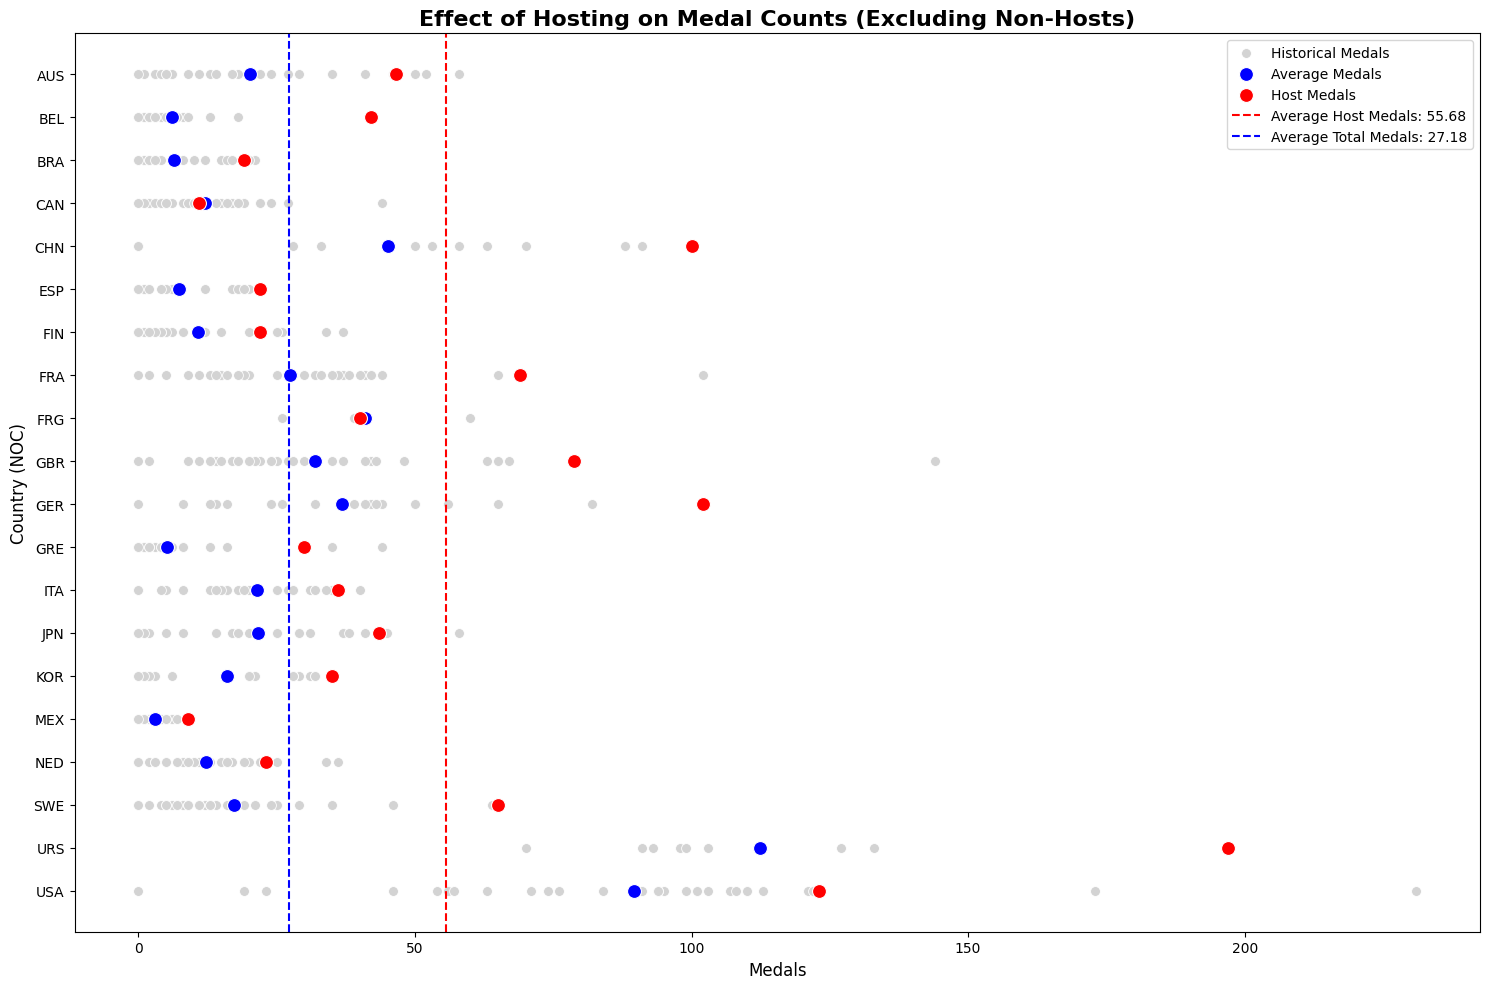

<Figure size 640x480 with 0 Axes>

In [10]:
# Plot for host effect
# Prepare data for EDA
train_eda = train.groupby(['Year', 'NOC'])[['Gold', 'Silver', 'Bronze']].sum().sort_values(by=['Year', 'Gold', 'Silver', 'Bronze'], ascending=[False, False, False, False]).reset_index()
train_eda = merge_hosts(train_eda, hosts)
train_eda

df_new = train_eda.copy()
df_new['Total_Medals'] = df_new[['Gold', 'Silver', 'Bronze']].sum(axis=1)

host_data = df_new[df_new['NOC_if_host'] == 1]
host_medals = host_data.groupby('NOC')['Total_Medals'].mean().reset_index()
host_medals.columns = ['NOC', 'Host_Medals']

country_avg_medals = df_new.groupby('NOC')[['Gold', 'Silver', 'Bronze']].mean().sum(axis=1).reset_index()
country_avg_medals.columns = ['NOC', 'Avg_Medals']

historical_medals = df_new.groupby(['NOC', 'Year'])['Total_Medals'].sum().reset_index()

final_data = country_avg_medals.merge(host_medals, on='NOC', how='left').fillna(0)
final_data = final_data.sort_values(by='Avg_Medals', ascending=False)
final_data = final_data[final_data['Host_Medals'] > 0]

# For each countries, Average Medal and Host Medal and all historical medals
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=historical_medals[historical_medals['NOC'].isin(final_data['NOC'])],
    x='Total_Medals',
    y='NOC',
    color='lightgray',
    s=50,
    label='Historical Medals',
)
sns.scatterplot(
    data=final_data,
    x='Avg_Medals',
    y='NOC',
    color='blue',
    s=100,
    label='Average Medals',
)
sns.scatterplot(
    data=final_data,
    x='Host_Medals',
    y='NOC',
    color='red',
    s=100,
    label='Host Medals',
)

avg_host_medals = final_data['Host_Medals'].mean()
avg_total_medals = final_data['Avg_Medals'].mean()

plt.axvline(avg_host_medals, color='red', linestyle='--', label=f'Average Host Medals: {avg_host_medals:.2f}')
plt.axvline(avg_total_medals, color='blue', linestyle='--', label=f'Average Total Medals: {avg_total_medals:.2f}')
plt.title('Effect of Hosting on Medal Counts (Excluding Non-Hosts)', fontsize=16, fontweight='bold')
plt.xlabel('Medals', fontsize=12)
plt.ylabel('Country (NOC)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("Effect of Hosting on Medal Counts (Excluding Non-Hosts).png", dpi=300, bbox_inches='tight')


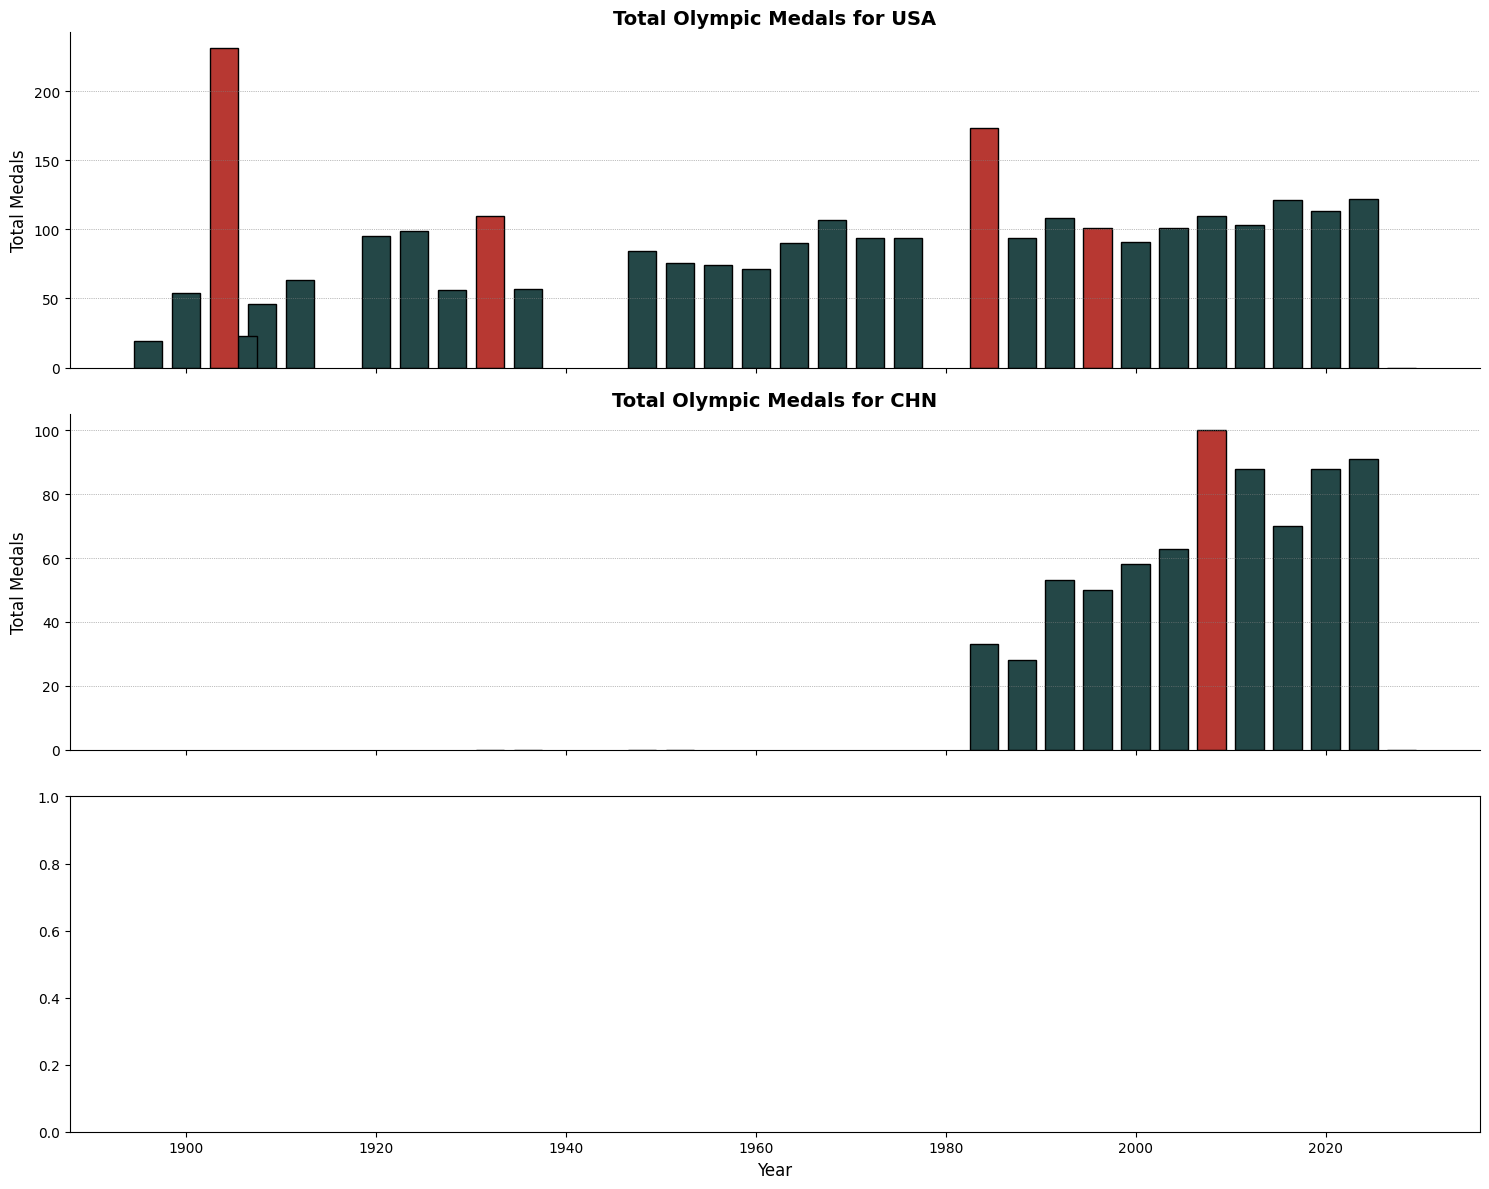

In [11]:
# Total Medals for Countries Through Time
countries = ['USA', 'CHN']
filtered_data = df_new[df_new['NOC'].isin(countries)]

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

for i, country in enumerate(countries):
    temp = filtered_data[filtered_data['NOC'] == country]
    color = ['#B73832' if is_host == 1 else '#244747' for is_host in temp['NOC_if_host']]

    axes[i].bar(temp['Year'], temp['Total_Medals'], width=3, color=color, edgecolor='black')
    axes[i].set_title(f'Total Olympic Medals for {country}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Total Medals', fontsize=12)
    axes[i].grid(axis='y', linestyle=':', linewidth=0.5, color='gray')

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

axes[-1].set_xlabel('Year', fontsize=12)
plt.tight_layout()
plt.show()


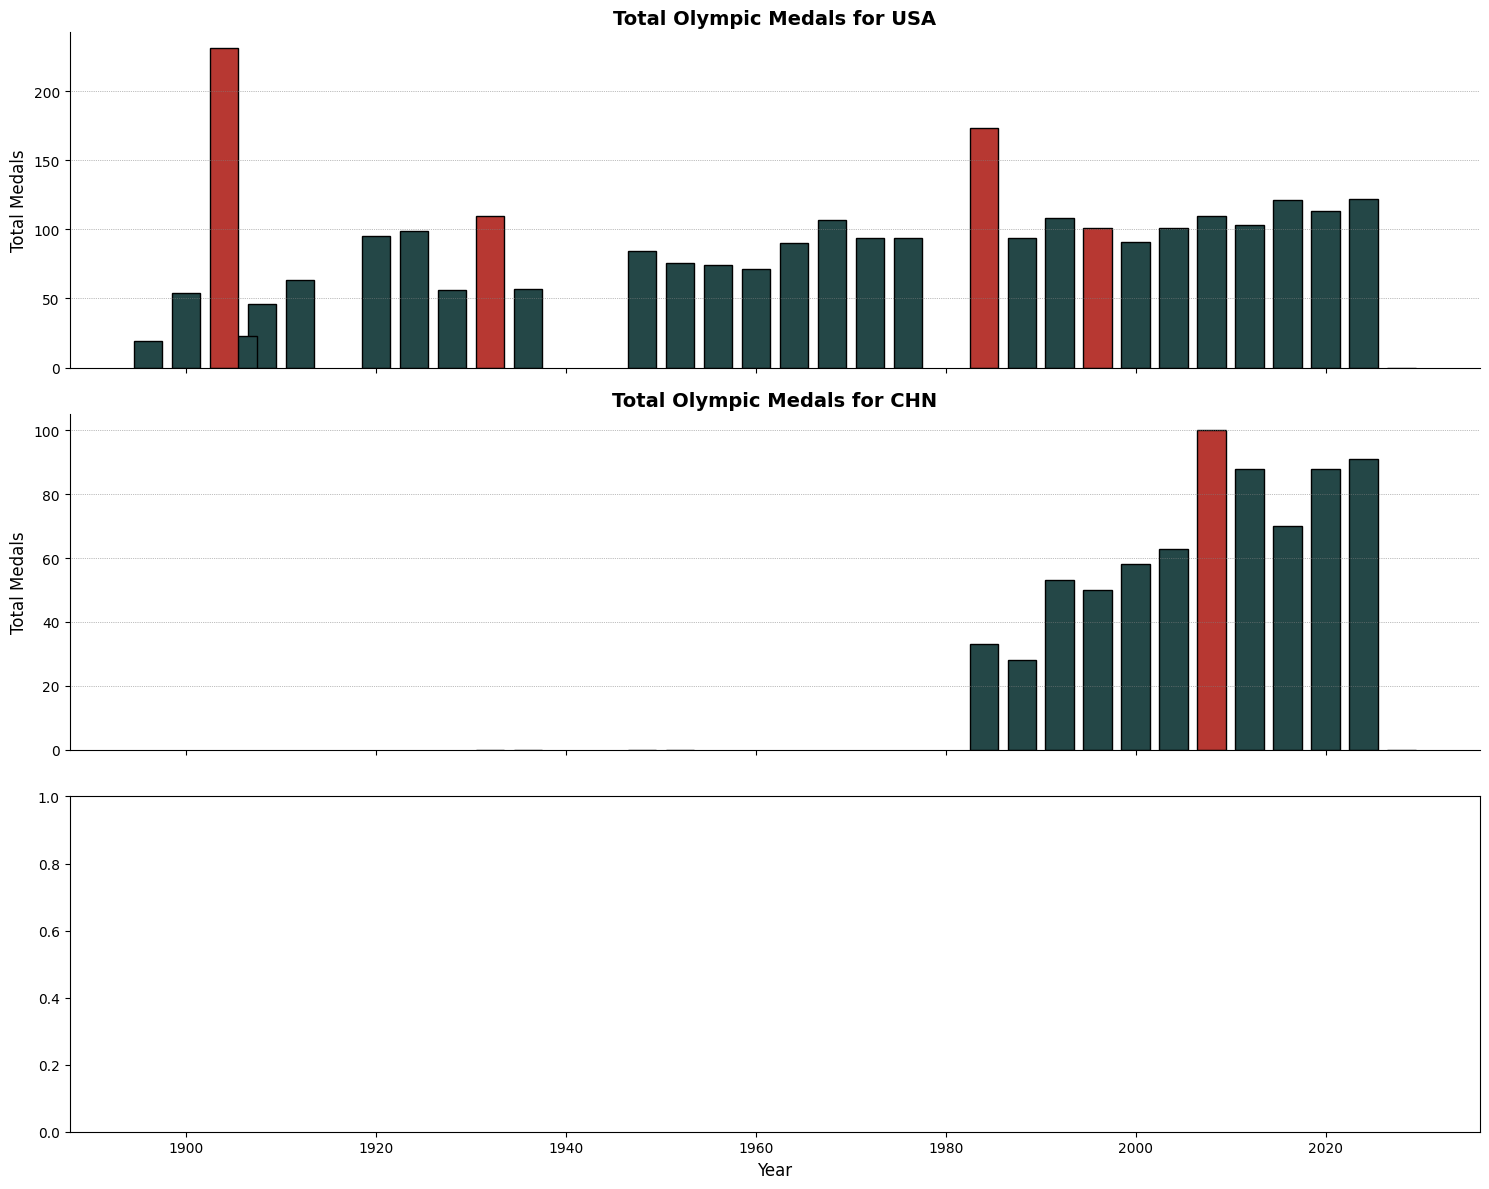

<Figure size 640x480 with 0 Axes>

In [12]:
# Total Medals for Countries Through Time
countries = ['USA', 'CHN']
filtered_data = df_new[df_new['NOC'].isin(countries)]

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

for i, country in enumerate(countries):
    temp = filtered_data[filtered_data['NOC'] == country]
    color = ['#B73832' if is_host == 1 else '#244747' for is_host in temp['NOC_if_host']]

    axes[i].bar(temp['Year'], temp['Total_Medals'], width=3, color=color, edgecolor='black')
    axes[i].set_title(f'Total Olympic Medals for {country}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Total Medals', fontsize=12)
    axes[i].grid(axis='y', linestyle=':', linewidth=0.5, color='gray')

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

axes[-1].set_xlabel('Year', fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig("Total Medals for Host and Not Host Years.png", dpi=300, bbox_inches='tight')


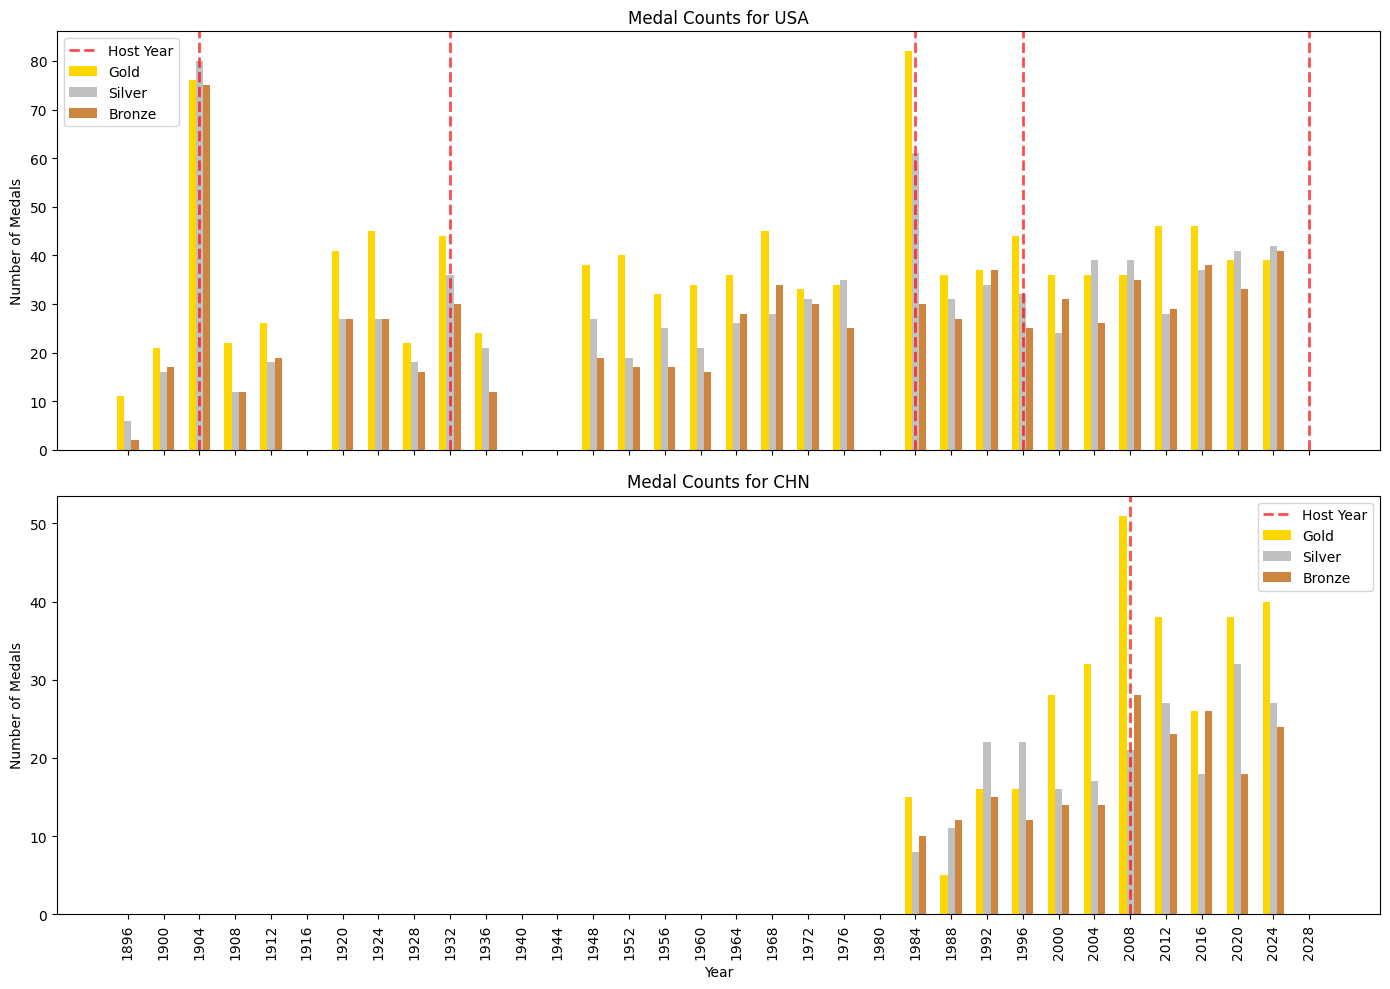

<Figure size 640x480 with 0 Axes>

In [13]:
# Gold, Silver, Bronze for countries in each year
medals_by_year = filtered_data.groupby(['Year', 'NOC'])[['Gold', 'Silver', 'Bronze']].sum().reset_index()

host_years = df_new[df_new['NOC_if_host'] == 1].groupby('NOC')['Year'].unique().reset_index()
host_years = {row['NOC']: row['Year'] for _, row in host_years.iterrows()}

all_years = np.arange(medals_by_year['Year'].min(), medals_by_year['Year'].max() + 1, 4)

fig, axes = plt.subplots(nrows=len(countries), ncols=1, figsize=(14, 10), sharex=True)
bar_width = 0.2

for i, country in enumerate(countries):
    country_data = medals_by_year[medals_by_year['NOC'] == country]
    country_data_full = pd.DataFrame({'Year': all_years})
    country_data_full = country_data_full.merge(country_data, on='Year', how='left').fillna(0)

    years = country_data_full['Year']
    gold = country_data_full['Gold']
    silver = country_data_full['Silver']
    bronze = country_data_full['Bronze']
    
    x = np.arange(len(years))
    
    axes[i].bar(x - bar_width, gold, width=bar_width, label='Gold', color='gold')
    axes[i].bar(x, silver, width=bar_width, label='Silver', color='silver')
    axes[i].bar(x + bar_width, bronze, width=bar_width, label='Bronze', color='peru')
    
    if country in host_years:
        for year in host_years[country]:
            if year in years.values:
                year_index = np.where(years == year)[0][0]
                axes[i].axvline(x=year_index, color='red', linestyle='--', linewidth=2, alpha=0.7, 
                                label='Host Year' if year == host_years[country][0] else "")
    
    axes[i].set_title(f'Medal Counts for {country}')
    axes[i].set_ylabel('Number of Medals')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(years, rotation=90)  # Rotate x-axis labels vertically
    axes[i].legend()

axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()
plt.savefig("Medals for Host and Not Host Years.png", dpi=300, bbox_inches='tight')


Key Statistics
Mean Natural Log of Total Medals when Not Hosting: 2.370
Mean Natural Log of Total Medals when Hosting: 3.787
Standard Error of Natural Log of Total Medals when Not Hosting: 0.059
Standard Error of Natural Log of Total Medals when Hosting: 0.192
Standard Errors between means: 7.067

T-Test
Statistics = -5.954, p-value = 0.000
Different distributions (reject H0)


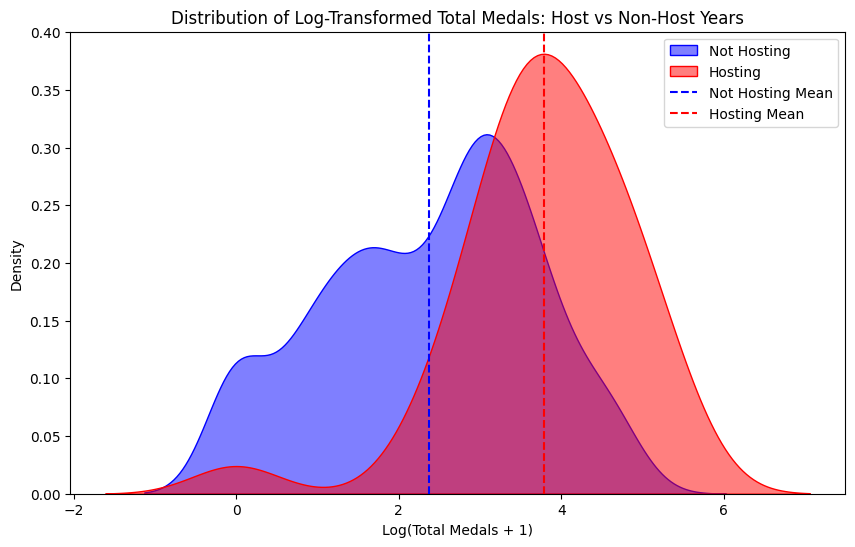

In [14]:
# Statistic test
#To determine whether hosting the Olympics has a statistically significant effect on medal counts, we conducted a hypothesis test comparing the total medals won during host and non-host years. Since the total medals data is positively skewed, we applied a log transformation (using np.log1p) to make the distribution more normal, which is a key assumption for the t-test. We filtered the dataset to include only countries that have hosted the Olympics at least once, ensuring a fair comparison between host and non-host years for the same set of countries. The data was then split into two groups: host years (NOC_if_host == 1) and non-host years (NOC_if_host == 0). After applying the log transformation, we performed an independent two-sample t-test to compare the means of the log-transformed total medals between the two groups. The null hypothesis (H₀) was that the means are equal (no host effect), while the alternative hypothesis (H₁) was that the means are not equal (host effect exists). We calculated key statistics, including the means, standard errors, and the standardized difference between means. The t-test yielded a very small p-value (p < 0.05), leading us to reject the null hypothesis and conclude that there is a statistically significant difference in medal counts between host and non-host years. This suggests a host effect, where countries tend to win more medals when hosting the Olympics. The log transformation was crucial to ensure the validity of the t-test by addressing the skewness in the data.
df_new['Total_Medals'] = df_new[['Gold', 'Silver', 'Bronze']].sum(axis=1)

df_new['Total_Medals_NaturalLog'] = np.log1p(df_new['Total_Medals'])  # log(1 + x) to handle zeros

host_countries = df_new[df_new['NOC_if_host'] == 1]['NOC'].unique()
df_filtered = df_new[df_new['NOC'].isin(host_countries)]

host_data = df_filtered[df_filtered['NOC_if_host'] == 1]
non_host_data = df_filtered[df_filtered['NOC_if_host'] == 0]

not_hosting_mean = non_host_data['Total_Medals_NaturalLog'].mean()
hosting_mean = host_data['Total_Medals_NaturalLog'].mean()

not_hosting_std = non_host_data['Total_Medals_NaturalLog'].std()
hosting_std = host_data['Total_Medals_NaturalLog'].std()

not_hosting_samples = non_host_data['Total_Medals_NaturalLog'].count()
hosting_samples = host_data['Total_Medals_NaturalLog'].count()

not_hosting_std_error = not_hosting_std / np.sqrt(not_hosting_samples)
hosting_std_error = hosting_std / np.sqrt(hosting_samples)

difference = hosting_mean - not_hosting_mean
combined_std_error = np.sqrt((not_hosting_std**2 / not_hosting_samples) + (hosting_std**2 / hosting_samples))

stat, p = ttest_ind(non_host_data['Total_Medals_NaturalLog'], host_data['Total_Medals_NaturalLog'])

print("Key Statistics")
print(f"Mean Natural Log of Total Medals when Not Hosting: {not_hosting_mean:.3f}")
print(f"Mean Natural Log of Total Medals when Hosting: {hosting_mean:.3f}")
print(f"Standard Error of Natural Log of Total Medals when Not Hosting: {not_hosting_std_error:.3f}")
print(f"Standard Error of Natural Log of Total Medals when Hosting: {hosting_std_error:.3f}")
print(f"Standard Errors between means: {difference / combined_std_error:.3f}")

print("\nT-Test")
print(f"Statistics = {stat:.3f}, p-value = {p:.3f}")
if p < 0.05:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

plt.figure(figsize=(10, 6))
sns.kdeplot(non_host_data['Total_Medals_NaturalLog'], label='Not Hosting', color='blue', shade=True, alpha=0.5)
sns.kdeplot(host_data['Total_Medals_NaturalLog'], label='Hosting', color='red', shade=True, alpha=0.5)
plt.axvline(not_hosting_mean, color='blue', linestyle='--', label='Not Hosting Mean')
plt.axvline(hosting_mean, color='red', linestyle='--', label='Hosting Mean')
plt.title('Distribution of Log-Transformed Total Medals: Host vs Non-Host Years')
plt.xlabel('Log(Total Medals + 1)')
plt.ylabel('Density')
plt.legend()
plt.show()

233
213


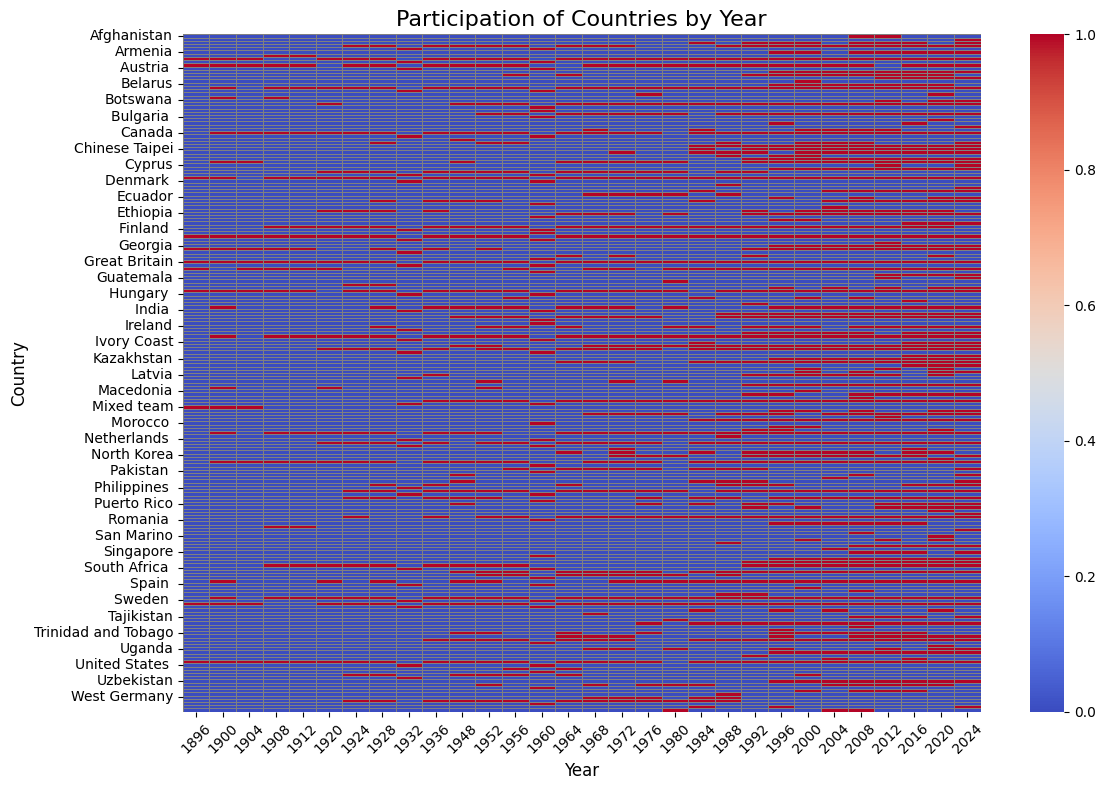

In [15]:
# Country Participation
print(len(athletes['NOC'].unique()))
print(len(athletes[athletes['Year']>1999]['NOC'].unique()))
set(athletes['NOC'].unique()) - set(athletes[athletes['Year']>1999]['NOC'].unique())

all_years = medal['Year'].unique()
all_countries = medal['NOC'].unique()

full_grid = pd.MultiIndex.from_product([all_years, all_countries], names=['Year', 'NOC'])
full_df = pd.DataFrame(index=full_grid).reset_index()

participation = pd.merge(full_df, medal[['Year', 'NOC']], on=['Year', 'NOC'], how='left', indicator=True)

participation['Participated'] = (participation['_merge'] == 'both').astype(int)

pivot_table = participation.pivot(index='NOC', columns='Year', values='Participated').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap="coolwarm", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Participation of Countries by Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

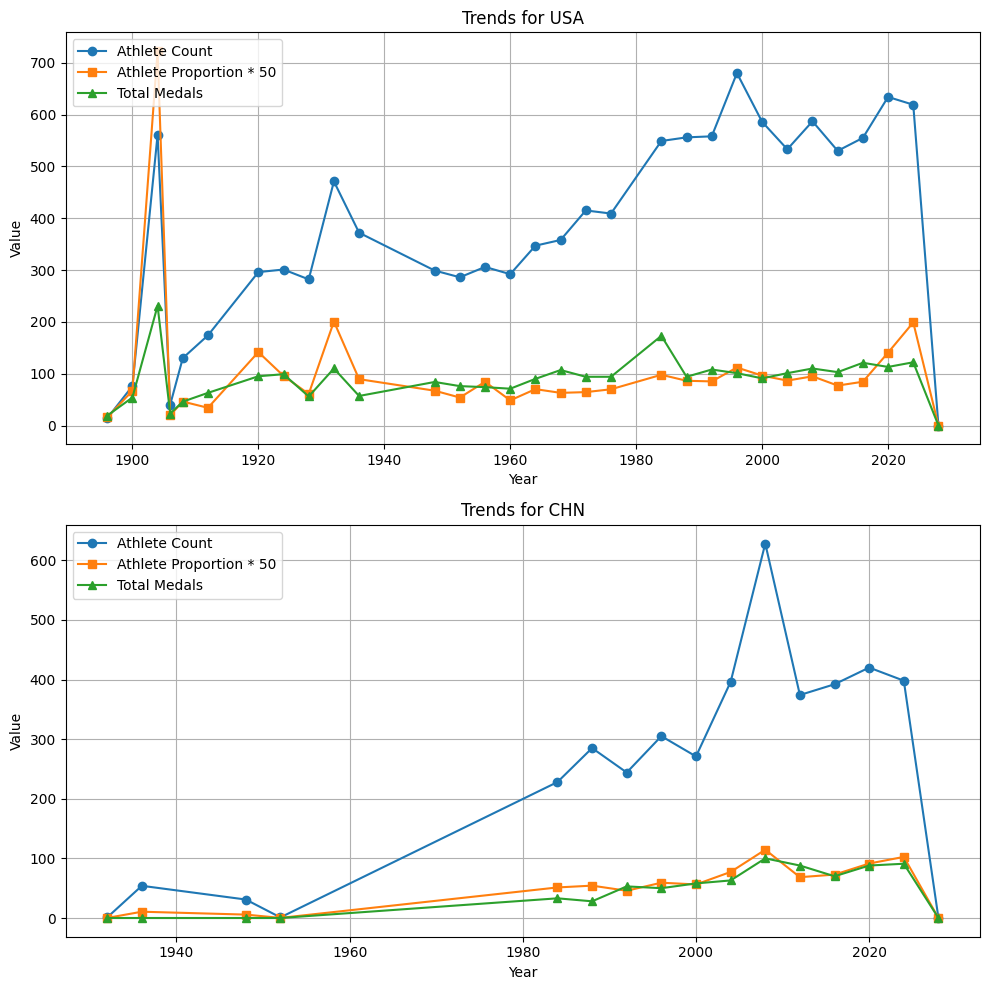

In [16]:
athletes_effect = train.loc[:, ['Year', 'NOC', 'Gold', 'Silver','Bronze', 'Athlete_Count', 'Athlete_Proportion']].groupby(['Year', 'NOC']).sum().reset_index()
athletes_effect['Total_Medals'] = athletes_effect['Gold'] + athletes_effect['Silver'] + athletes_effect['Bronze']

selected_countries = ['USA', 'CHN']
filtered_data = athletes_effect[athletes_effect['NOC'].isin(selected_countries)]

# Plot trends for each country
fig, axes = plt.subplots(len(selected_countries), 1, figsize=(10, 5 * len(selected_countries)))

for i, country in enumerate(selected_countries):
    country_data = filtered_data[filtered_data['NOC'] == country]
    axes[i].plot(country_data['Year'], country_data['Athlete_Count'], label='Athlete Count', marker='o')
    axes[i].plot(country_data['Year'], country_data['Athlete_Proportion']*50, label='Athlete Proportion * 50', marker='s')
    axes[i].plot(country_data['Year'], country_data['Total_Medals'], label='Total Medals', marker='^')
    
    # Set titles and labels
    axes[i].set_title(f'Trends for {country}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



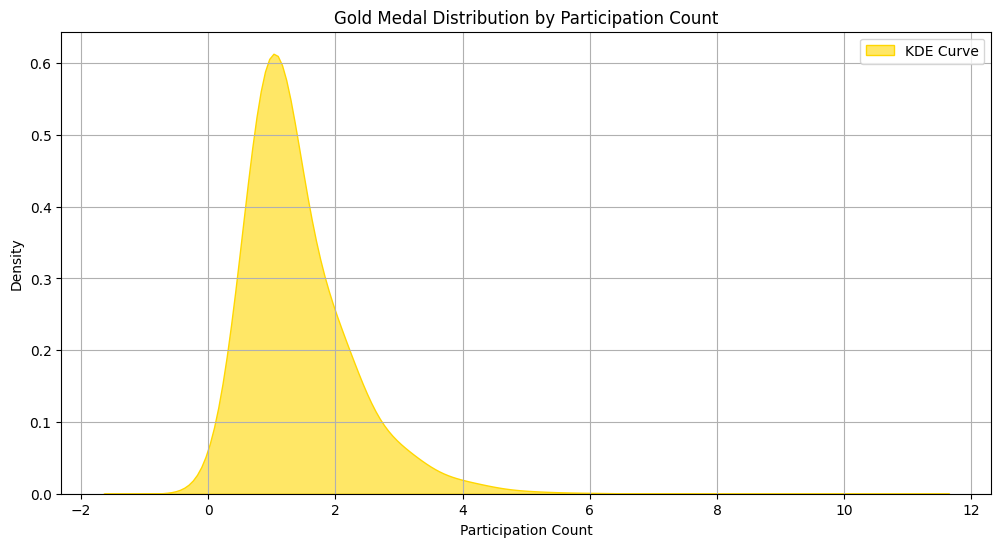

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


athletes['Gold'] = (athletes['Medal'] == 'Gold').astype(int)
athletes['Participation_Count'] = (athletes.drop_duplicates(subset=["Name", "Year"], keep=False)
                                   .groupby('Name').cumcount() + 1).astype(int)
gold_distribution = athletes.groupby('Participation_Count')['Gold'].sum().reset_index()


plt.figure(figsize=(12, 6))
sns.kdeplot(
    x=gold_distribution['Participation_Count'],
    weights=gold_distribution['Gold'],
    bw_adjust=0.5,
    fill=True,
    color='gold',
    label='KDE Curve',
    alpha=0.6
)

plt.xlabel('Participation Count')
plt.ylabel('Density')
plt.title('Gold Medal Distribution by Participation Count')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Gold/Silver score received calculated using host
# Medal calculated by aveage medal earned with(out) host
Average_Medal_With_Host = 55.68
Average_Total_Medal = 21.18
train_medal = (
    athletes[['Name','Sport','Year', 'NOC', 'Medal']]
    .drop_duplicates()
    .groupby(['Name','Sport','Year', 'NOC', 'Medal'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
).sort_values(by=['Year', 'Gold', 'Silver', 'Bronze'], ascending=[False, False, False, False])


In [19]:
athletes

,Name,Sex,Team,NOC,Year,City,Sport,Event,Medal,Gold,Participation_Count
0,A Dijiang,M,China,CHN,1992,Barcelona,Basketball,Basketball Men's Basketball,No medal,0,1.0
1,A Lamusi,M,China,CHN,2012,London,Judo,Judo Men's Extra-Lightweight,No medal,0,1.0
2,Gunnar Aaby,M,Denmark,DEN,1920,Antwerpen,Football,Football Men's Football,No medal,0,1.0
3,Edgar Aabye,M,Denmark/Sweden,DEN,1900,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,1,1.0
4,Cornelia (-strannood),F,Netherlands,NED,1932,Los Angeles,Athletics,Athletics Women's 100 metres,No medal,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
252560,Sefora Ada,F,Equatorial Guinea,GEQ,2024,Paris,Athletics,Women's 100m,No medal,0,1.0
252561,Emanuela Liuzzi,F,Italy,ITA,2024,Paris,Wrestling,Women's Freestyle 50kg,No medal,0,1.0
252562,Isayah Boers,M,Netherlands,NED,2024,Paris,Athletics,4 x 400m Relay Mixed,Gold,1,1.0
252563,Kevin Staut,M,France,FRA,2024,Paris,Equestrian,Jumping Team,Bronze,0,1.0


In [20]:
train_medal

Medal,Name,Sport,Year,NOC,Bronze,Gold,No medal,Silver
48152,Femke Bol,Athletics,2024,NED,1,1,0,1
91034,Katie Ledecky,Swimming,2024,USA,1,1,0,1
115541,McKEON Emma,Swimming,2024,AUS,1,1,1,1
115543,McKEOWN Kaylee,Swimming,2024,AUS,1,1,0,1
121300,Mollie O'callaghan,Swimming,2024,AUS,1,1,1,1
...,...,...,...,...,...,...,...,...
156348,Stamatios Masouris,Athletics,1896,GRE,0,0,1,0
162044,Theodor Leupolt,Cycling,1896,GER,0,0,1,0
167546,Vasilios Xydas,Athletics,1896,GRE,0,0,1,0
167668,Vavis,Shooting,1896,GRE,0,0,1,0


In [21]:
# train_medal['Gold'] = (train_medal['Gold']).astype(int)
# train_medal['Silver'] = (train_medal['Silver']).astype(int)
# train_medal['Bronze'] = (train_medal['Bronze']).astype(int)

athletes['Participation_Count'] = (athletes.drop_duplicates(subset=["Name", "Year"], keep=False)
                                   .groupby('Name').cumcount() + 1).astype(int)
# df = train_medal.merge(athletes,on=["Name","Sport","Year","NOC"],how='right')
athletes

,Name,Sex,Team,NOC,Year,City,Sport,Event,Medal,Gold,Participation_Count
0,A Dijiang,M,China,CHN,1992,Barcelona,Basketball,Basketball Men's Basketball,No medal,0,1.0
1,A Lamusi,M,China,CHN,2012,London,Judo,Judo Men's Extra-Lightweight,No medal,0,1.0
2,Gunnar Aaby,M,Denmark,DEN,1920,Antwerpen,Football,Football Men's Football,No medal,0,1.0
3,Edgar Aabye,M,Denmark/Sweden,DEN,1900,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,1,1.0
4,Cornelia (-strannood),F,Netherlands,NED,1932,Los Angeles,Athletics,Athletics Women's 100 metres,No medal,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
252560,Sefora Ada,F,Equatorial Guinea,GEQ,2024,Paris,Athletics,Women's 100m,No medal,0,1.0
252561,Emanuela Liuzzi,F,Italy,ITA,2024,Paris,Wrestling,Women's Freestyle 50kg,No medal,0,1.0
252562,Isayah Boers,M,Netherlands,NED,2024,Paris,Athletics,4 x 400m Relay Mixed,Gold,1,1.0
252563,Kevin Staut,M,France,FRA,2024,Paris,Equestrian,Jumping Team,Bronze,0,1.0


In [22]:

# Sum medals (gold, silver, bronze) for each participation count
medal_distributions = train_medal.groupby('Participation_Count')[['Gold', 'Silver', 'Bronze']].sum().reset_index()

# Plotting KDE for Gold, Silver, and Bronze Medals
plt.figure(figsize=(12, 8))

# Gold KDE
sns.kdeplot(
    x=medal_distributions['Participation_Count'],
    weights=medal_distributions['Gold'],
    bw_adjust=0.5,
    fill=True,
    color='gold',
    label='Gold Medal KDE',
    alpha=0.6
)

# Silver KDE
sns.kdeplot(
    x=medal_distributions['Participation_Count'],
    weights=medal_distributions['Silver'],
    bw_adjust=0.5,
    fill=True,
    color='silver',
    label='Silver Medal KDE',
    alpha=0.6
)

# Bronze KDE
sns.kdeplot(
    x=medal_distributions['Participation_Count'],
    weights=medal_distributions['Bronze'],
    bw_adjust=0.5,
    fill=True,
    color='brown',
    label='Bronze Medal KDE',
    alpha=0.6
)


plt.xlabel('Participation Count')
plt.ylabel('Density')
plt.title('Medal Distribution by Participation Count (Gold, Silver, Bronze)')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'Participation_Count'

In [59]:
train_medal["Sum"] = train_medal["Gold"]+train_medal["Silver"]+train_medal["Bronze"]+train_medal["No medal"]

train_medal = train_medal.merge(
    train[['Year', 'NOC', 'NOC_if_host']],
    on=['Year', 'NOC'],
    how='left'
)

train_medal["Host_Bonus"] = train_medal["NOC_if_host"].apply(lambda x: 1 if x else 0)

train_medal = train_medal.drop_duplicates(["Name","Sport","Year","NOC"])

# If you want a specific formula for Gold Score, modify as needed
train_medal["Gold Score"] = (train_medal["Gold"] / train_medal["Sum"]-train_medal["Host_Bonus"]*train_medal["Gold"]*(Average_Total_Medal/Average_Medal_With_Host))
train_medal["Silver Score"] = (train_medal["Silver"] / train_medal["Sum"]-train_medal["Host_Bonus"]*train_medal["Silver"]*(Average_Total_Medal/Average_Medal_With_Host))
train_medal["Bronze Score"] = (train_medal["Bronze"] / train_medal["Sum"]-train_medal["Host_Bonus"]*train_medal["Bronze"]*(Average_Total_Medal/Average_Medal_With_Host))


In [21]:
train

,Year,NOC,Gold,Silver,Bronze,No medal,Athlete_Count,Total_Athlete_Count,Athlete_Proportion,NOC_host,NOC_if_host,Sport_Code,Number_of_Events,EWA
27586,1936,AFG,0,0,0,3,2,776,0.002577,GER,0,ATH,29,0.0
27587,1936,AFG,0,0,0,1,13,167,0.077844,GER,0,HOC,1,0.0
27073,1948,AFG,0,0,0,1,10,217,0.046083,GBR,0,FBL,1,0.0
27074,1948,AFG,0,0,0,1,12,184,0.065217,GBR,0,HOC,1,0.0
25992,1956,AFG,0,0,0,1,12,173,0.069364,AUS,0,HOC,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,2028,ZIM,0,0,0,0,0,0,0.000000,USA,0,ROW,NaN,NaN
3450,2028,ZIM,0,0,0,0,0,0,0.000000,USA,0,SHO,NaN,NaN
3451,2028,ZIM,0,0,0,0,0,0,0.000000,USA,0,SWM,NaN,NaN
3452,2028,ZIM,0,0,0,0,0,0,0.000000,USA,0,TEN,NaN,NaN


In [2]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [3]:
train.column

NameError: name 'train' is not defined

In [ ]:
# ['Gold']
# ['Silver']
# ['Bronze']

In [36]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def XGB(X, y):
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store models and their accuracies
    models = []
    accuracies = []

    # K-Fold Cross Validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Convert the dataset into XGBoost's DMatrix format
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Set up the parameters for the XGBoost model
        params = {
            'objective': 'multi:softmax',  # Multi-class classification
            'num_class': len(set(y)),     # Number of unique classes
            'max_depth': 3,               # Maximum depth of trees
            'eta': 0.3,                   # Learning rate
            'seed': 42
        }

        # Train the model
        num_round = 50  # Number of boosting rounds
        model = xgb.train(params, dtrain, num_round)

        # Make predictions
        y_pred = model.predict(dtest)
        y_pred = y_pred.astype(int)  # Ensure predictions are integers

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
        
        # Store model and accuracy
        models.append(model)
        accuracies.append(accuracy)

    # Return all models and their corresponding accuracies
    return models, accuracies


In [38]:
X = train.drop(["Gold","Silver","Bronze"],axis=1)
X = X[X["Year"]!=2028]
models, accuracies = XGB(X, train[["Gold"]])
print(f"\nAll fold accuracies: {accuracies}")
print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.2f}")

KeyError: "None of [Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,    10,\n       ...\n       26459, 26460, 26461, 26462, 26463, 26464, 26465, 26466, 26467, 26468],\n      dtype='int32', length=21175)] are in the [columns]"

In [39]:
X

,Year,NOC,No medal,Athlete_Count,Total_Athlete_Count,Athlete_Proportion,NOC_host,NOC_if_host,Sport_Code,Number_of_Events,EWA
27586,1936,AFG,3,2,776,0.002577,GER,0,ATH,29,0.000000
27587,1936,AFG,1,13,167,0.077844,GER,0,HOC,1,0.000000
27073,1948,AFG,1,10,217,0.046083,GBR,0,FBL,1,0.000000
27074,1948,AFG,1,12,184,0.065217,GBR,0,HOC,1,0.000000
25992,1956,AFG,1,12,173,0.069364,AUS,0,HOC,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
7700,2020,ZIM,1,1,522,0.001916,JPN,0,ROW,14.0,0.001102
7701,2020,ZIM,2,2,879,0.002275,JPN,0,SWM,35.0,0.000882
5542,2024,ZIM,3,4,2019,0.001981,FRA,0,ATH,48.0,0.000705
5543,2024,ZIM,1,1,493,0.002028,FRA,0,ROW,14.0,0.000564
